## Speech to text - training

This jupyter notebook will describe from scratch how to work over speech data (signal) and how to reproduce into text that information. The data sets used for this task are stored in: https://commonvoice.mozilla.org/es/datasets

#### Signal processing

Some basics on signal knowledge:
* Sound - signal
* The sound produces a signal which basically it is the vibration of the air. The negatives values comes from a reference point (0) which allows us to measure how is the wave vibration.
* It is importante to emphasizes that without vibration, it does not matter the high of the signal we would not hear anything. That is we identify sounds by using the changes in vibration frequency (a little hint of fourier transformation to get the frequency representation of the signal)

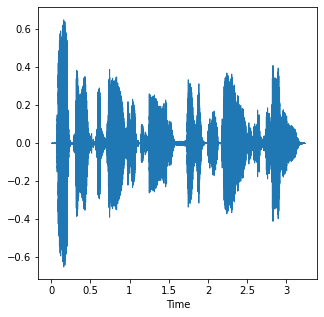

In [1]:
import librosa
import librosa.display
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

FILES_LIMIT = 1
SAMPLING_RATE = 16000

relative_path = 'data/NLP/speech/cmu_us_bdl_arctic/wav/'

onlyfiles = [relative_path+f for f in listdir(relative_path) if isfile(join(relative_path, f))]

for i,file in enumerate(onlyfiles):
    if i == FILES_LIMIT:
        break
    wave, _ = librosa.load(file, sr=SAMPLING_RATE)
    plt.figure(figsize = (5,5))
    librosa.display.waveshow(wave, sr=SAMPLING_RATE)
    plt.show()

#### Custom signal

In [25]:
def gen_sin(freq, amplitude, sr=16000):
    return np.sin((freq * 2 * np.pi * np.linspace(0, sr, sr)) / sr) * amplitude


* The next example shows a signal with:
    * 3 full periods
    * 30 full periods
* The period (length between wave peaks) or $P = \frac{1}{freq}$ is get as $freq = \frac{sr}{P}$

<AxesSubplot:>

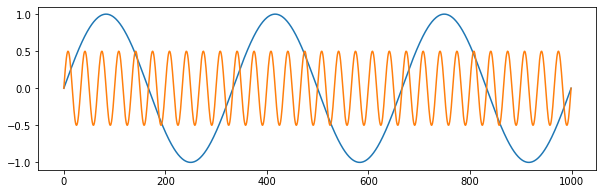

In [3]:
import seaborn as sns
import numpy as np
plt.figure(figsize = (10,3))
sns.lineplot(data=gen_sin(3, 1))
# Wave with more freq but less amplitute
sns.lineplot(data=gen_sin(30, 0.5))

A pretty good question might be: "What we got if we add different signals?".
* Obvious and correct answer: $$s_{total} = \sum_{i = 1}^ns_i$$
* ¿Problem?
* Let's see:
    * Same signal

<AxesSubplot:>

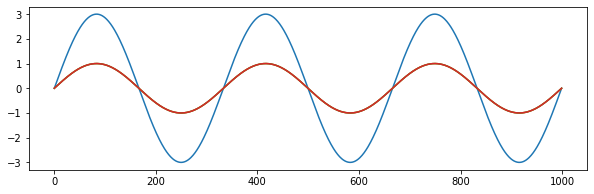

In [4]:
sig_1 = gen_sin(3, 1)
sig_2 = gen_sin(3, 1)
sig_3 = gen_sin(3, 1)
plt.figure(figsize = (10,3))
sns.lineplot(data=sig_1+sig_2+sig_3)
sns.lineplot(data=sig_1)
sns.lineplot(data=sig_2)
sns.lineplot(data=sig_3)

No problem at all

* Different signals:
    * Reverse
    * Simply different

<AxesSubplot:>

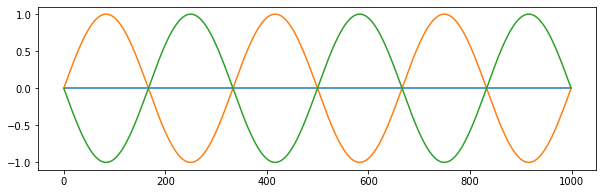

In [5]:
sig_1 = gen_sin(3, 1)
sig_2 = -sig_1
plt.figure(figsize = (10,3))
sns.lineplot(data=sig_1+sig_2)
sns.lineplot(data=sig_1)
sns.lineplot(data=sig_2)

<AxesSubplot:>

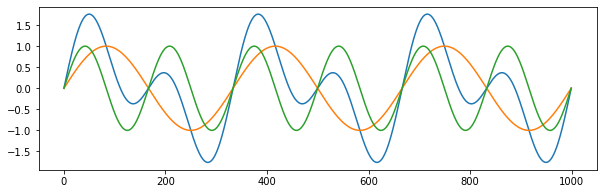

In [6]:
sig_1 = gen_sin(3, 1)
sig_2 = gen_sin(6,1)
plt.figure(figsize = (10,3))
sns.lineplot(data=sig_1+sig_2)
sns.lineplot(data=sig_1)
sns.lineplot(data=sig_2)

* Although obvious still funny

The past point looks pretty useless, however it points out that any signal can be built from the composition of $sin$ functions. This is even more extreme because any function can be approaximated by the linear composition of periodic functions $sin$ and $cos$, this is the base of Fourier Series.

In fact, Fourier transformation it is pretty important at this point because the difference between noise, sound and voices comes from their vibration frequencies and FT allows us to move from time space to frequency space. But what is this frequency space? Let's assume that we have a function $f(x)$ $$\mathcal{f}(\epsilon) = \int_{-\infty}^{\infty} f(x)e^{-2\pi j\epsilon x}dx$$ We are not physics so let's move to discrete space which makes everything simpler (xD) 
$$X[\epsilon] = \sum_{n = 0}^N X_ne^{-2 \pi j \epsilon n} = \sum_{n = 0}^{\infty} X_n (cos (2 \pi \epsilon n) - j sin (2 \pi \epsilon n))$$
Much much easier now, basically it establishs that all function $f(x)$ can be represented through a composition of periodic functions $sin$ and $cos$. For example, let's use the notation $W = e^{-2 \pi j \epsilon} = cos (2 \pi \epsilon) - j sin (2 \pi \epsilon)$ 
$$\mathcal{f}(\epsilon) = X_0W^0 + X_1W^1+\dots +X_{\infty}W^{\infty}$$ 
which indeed it is the composition of periodic functions. However, there is something strange "What with that $\infty$?", yep it does not makes sense since our data is tipically finite. From there raises FFT or Fast Fourier Transform, given a sample of size $N$ of a particular signal $X_0(\cdot)$ we can build the FFT from it as:
$$X(\epsilon) = \sum_{n = 1}^N X_0(n) e^{-2 \pi j \epsilon n}$$
under the same notation as before $W = e^{-2 \pi j \epsilon} = cos (2 \pi \epsilon) - j sin (2 \pi \epsilon)$
$$X(\epsilon) = X_0(0) W^0 + X_0(1)W^1+\dots +X_0(N)W^{N}$$
So basically the representation in frequency of a signal is the combination of the values of the function in the time domain $X_0$ and a periodic complex function $cos (2 \pi \epsilon) - j sin (2 \pi \epsilon)$. It is important to note that even for $\epsilon = 0$ all times participate!


Let's see how this works in practice

In [7]:
def build_signal_composition(pairs):
    waves = [gen_sin(f, amp) for f, amp in pairs]
    return waves, sum(waves)

<AxesSubplot:>

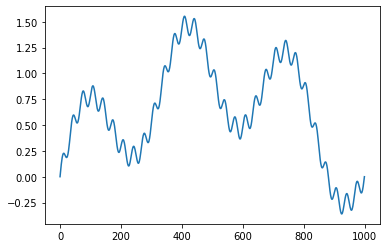

In [8]:
pairs = [(0.5,1), (3,0.5), (30,0.1)]
signals, sum_signals = build_signal_composition(pairs)
sns.lineplot(data = sum_signals)

<AxesSubplot:>

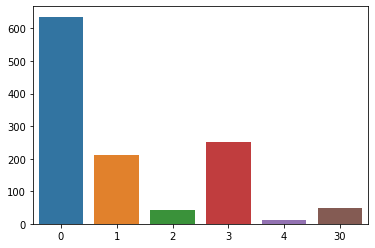

In [9]:
ffts = np.fft.fft(sum_signals)
freqs = np.fft.fftfreq(len(sum_signals))
pos = len(ffts) // 2
frequencies, coeffs = zip(*list(filter(lambda row: row[1] > 10, [ (int(abs(freq * 1000)), coef) for freq, coef in zip(freqs[0:pos], np.abs(ffts)[0:pos]) ])))
sns.barplot(x=list(frequencies), y=list(coeffs))

* What this plot means? Basically it gives us the frequencies where the coefficients are above one threshold, in other words the interesting frequencies. Those where we can assume there is some information, for the rest we can assume they are useless. A clear problem here - set the threshold. Another, way to see this is as the different frequencies in a speak process, it is not the same frequency when we start and when we end. Let's see an example:

In [78]:
import simpleaudio as sa 
import simpleaudio.functionchecks as fc 

f_name = 'data/NLP/speech/grabacion_ruido.wav'
  
wave_obj = sa.WaveObject.from_wave_file(f_name)    
play = wave_obj.play()  
            
play.wait_done()   
play.stop()

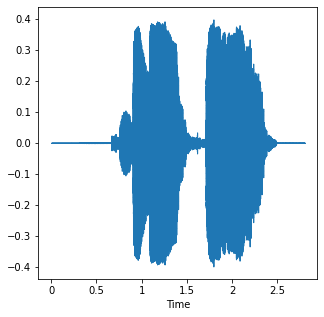

In [79]:
wave, _ = librosa.load(f_name, sr=SAMPLING_RATE)
plt.figure(figsize = (5,5))
librosa.display.waveshow(wave, sr=SAMPLING_RATE)
plt.show()

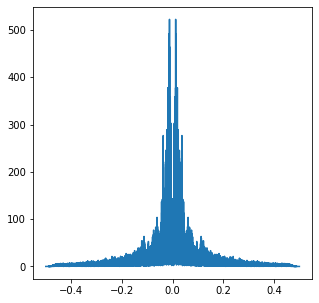

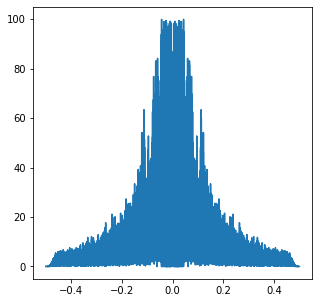

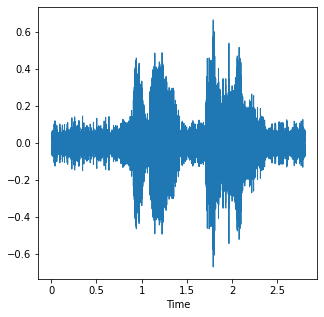

In [71]:
MIN_COEF = 100.0
# FFT
ffts = np.fft.fft(wave)
freqs = np.fft.fftfreq(len(wave))
plt.figure(figsize = (5,5))
sns.lineplot(x = freqs, y = abs(ffts))
plt.show()
ffts = np.array([0.0 if abs(coef) < MIN_COEF else coef for coef in ffts])
plt.figure(figsize = (5,5))
sns.lineplot(x = freqs, y = abs(ffts))
plt.show()
new_wave = abs(np.fft.ifft(ffts))
plt.figure(figsize = (5,5))
librosa.display.waveshow(new_wave, sr=SAMPLING_RATE)
plt.show()

* Let's build some extra waves to see the effect of different frequencies:
    * 800 Hz
    * 1000 Hz
    * 1200 Hz
    * 1400 Hz
    * 1600 Hz

In [85]:
from scipy.io.wavfile import write
freqs = np.array([8, 10, 12, 14, 16])*1000
for i, freq in enumerate(freqs):
    print('Freq: ',freq)
    sig = gen_sin(freq, amplitude = 10.0, sr = 16000)
    play_obj = sa.play_buffer(sig, 2, 2, SAMPLING_RATE)
    play_obj.wait_done()

Freq:  8000
Freq:  10000
Freq:  12000
Freq:  14000
Freq:  16000


* The expected result is to hear the difference for the cases where the frequency is low but by the time the frequency is increased the difference harder to detect. It is a well-known process and it has his own magnitute called *Mel-Scale*. That is the reason that many human speech recognition methods use the log-scale of intensities instead of the intensity itself. The resulting $time\times frequency(mels) \times log-intensity$ is called the log-Mel spectrogram.
$$mels = \mathcal{M}(f) = 2595\cdot log_{10}(1 + \frac{f}{700})$$

### Deep learning for speech recognition